# Denoising Diffusion Probabilistic Models with miniai

###  Inputs

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [2]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

### Load the Dataset 

Load the data from HuggingFace Hub

In [3]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

By default the dataloader returns a batch of items from the __getitem__ call.  Each item is a dictionary with two items, the image and the label.

The collate function needs to take these dict items and combine all of the images into a list and then stack them, as well as taking all of the labels and creating a tensor of them.  Use of the collate function can be avoided by using the HuggingFace with transform method of the dataset.

When we create a data loader with pytorch it knows how to collate dictionaries of tensors and so we do not need to pass in a collate function.  The above function has to return a dictionary of tensors (expected by Huggingface)

In [5]:
@inplace
def transformi(b): 
    b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

In [7]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=6)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

### Load Model 

Using a HuggingFace Unet model

In [10]:
from diffusers import UNet2DModel

In [11]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

In [12]:
model

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Con

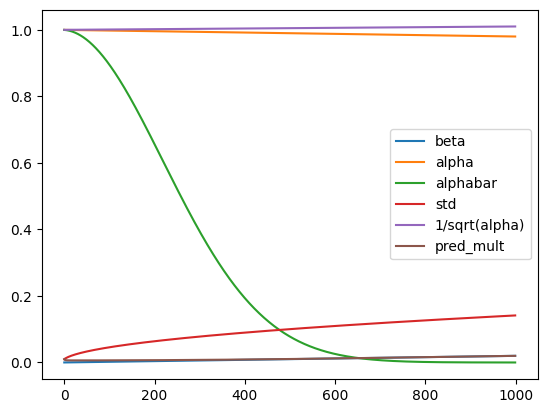

In [20]:
betamin=0.0001; betamax=0.02; nsteps=1000
beta = torch.linspace(betamin, betamax, nsteps)
alpha = (1-beta).to(def_device)
alphabar = torch.cumprod(alpha, dim=0).to(def_device)
std = beta.sqrt()
one_over_sqrt_alpha = 1/alpha.sqrt()
pred_mult = (1.-alpha) / (1.0-alphabar).sqrt()
plt.plot(range(0, nsteps), beta)
plt.plot(range(0, nsteps), alpha.cpu())
plt.plot(range(0, nsteps), alphabar.cpu())
plt.plot(range(0, nsteps), std.cpu())
plt.plot(range(0, nsteps), one_over_sqrt_alpha.cpu())
plt.plot(range(0, nsteps), pred_mult.cpu())

plt.legend(['beta', 'alpha', 'alphabar', 'std', '1/sqrt(alpha)', 'pred_mult'])
n=16

In [21]:
device = def_device
t = torch.randint(0, nsteps, (n,), device=device, dtype=torch.long)
alpha_t = alphabar[t].reshape(-1, 1, 1, 1).to(device)
t.shape, alpha_t.shape, def_device

(torch.Size([16]), torch.Size([16, 1, 1, 1]), 'cuda')

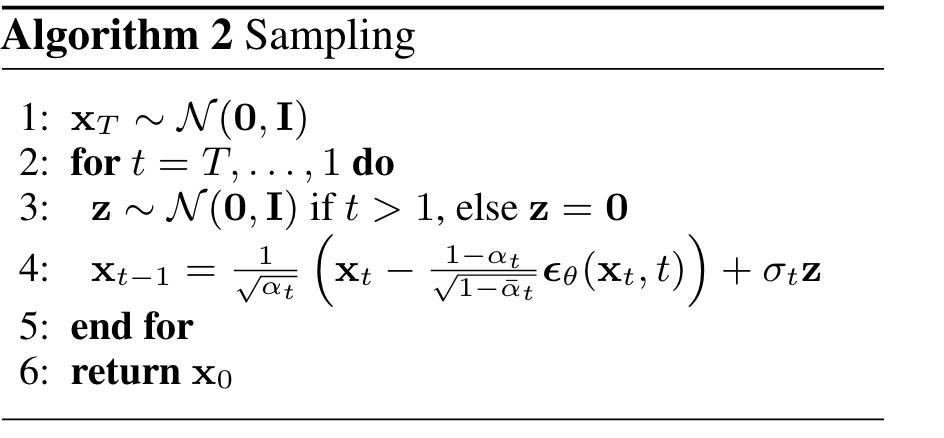


In [32]:
class DDPMCB(TrainCB):
    # Make sure this is called after the device call back
    order = DeviceCB.order + 1
    def __init__(self, n_steps, beta_min, beta_max):
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        super().__init__()
        # Create Beta, alpha and alphabar
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1-self.β
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()
    
    def predict(self, learn):
        learn.preds = learn.model(*learn.batch[0]).sample
    
    def before_batch(self, learn):
        # Load an image and move it to the device
        device = learn.batch[0].device
        # Generate a batch of random images on the appropriate device
        ε = torch.randn(learn.batch[0].shape, device=device)
        x0 = learn.batch[0]
        # send alphabar to the device
        self.ᾱ = self.ᾱ.to(device)
        # Define the size of the batch
        n = x0.shape[0]
        # get a random time
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        # Create random noise according to the timestep and apply.  At large values
        # of t alphabar is small and so little noise is added
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1. - ᾱ_t).sqrt() * ε
        # pass to the model the noised image, the time step, and the target, which is the
        # noise added
        learn.batch = ((xt, t), ε)
    
    @torch.no_grad()
    def sample(self, model, sz):
        # get the device from the model parameters. t is the interval at which we feed in the image
        # and t-1 is the next step
        device = next(model.parameters()).device
        # Create an array of random images to seed the process with
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            # Create an array with the values of t to apply to each image to be created
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t>0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1] if t>0 else torch.tensor(1)
            # beta coefficient at t
            b_t = (1.-self.ᾱ[t])
            #b_t = (1.-self.ᾱ[t])
            # beta coefficient at t-1
            b_t1 = 1. - ᾱ_t1
            noise_preds = learn.model(x_t, t_batch).sample
            # x_0_hat is an attemtp to remove all of the noise (equation (15 in the paper))
            x_0_hat = ((x_t - b_t.sqrt()*noise_preds) / self.ᾱ[t].sqrt()).clamp(-1, 1)
            # x0_coeff defines how much of the new random noise image we use
            x0_coeff = ᾱ_t1.sqrt()*(1.-self.α[t]) / b_t
            # xt_coeff defines how much of the original noised image we keep
            xt_coeff = self.α[t].sqrt()*b_t1/b_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds
    

In [33]:
lr=4e-3
epochs=5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)


loss,epoch,train
0.059,0,train
0.025,0,eval
0.022,1,train
0.020,1,eval
0.019,2,train
0.017,2,eval
0.017,3,train
0.017,3,eval
0.016,4,train
0.015,4,eval


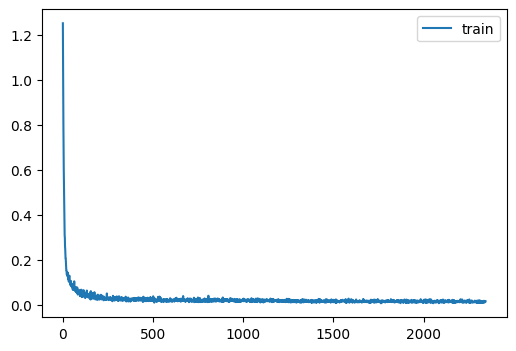

In [24]:
learn.fit(epochs)

In [25]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [26]:
torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [34]:
learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')

### Inference

In [35]:
set_seed(42)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
len(samples)

1000

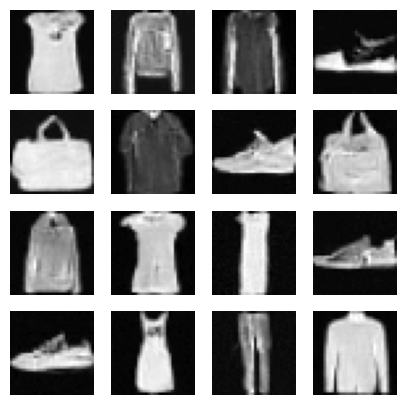

In [36]:
show_images(-samples[-1], figsize=(5,5))

In [ ]:
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML

fig,ax = plt.subplots(figsize=(3,3))
def _show_i(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = L.range(800,990, 5)+L.range(990,1000)+[999]*10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))